## Importing required libraries

In [1]:
# suppressing warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import accumulate
from pprint import pprint

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer 
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

from sklearn.manifold import TSNE
import plotly.graph_objs as go
from IPython.display import Markdown as md

#### Checking if CUDA is available

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


#### Defining helper functions

In [4]:
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()

    plt.show()

## The Dataset

#### Printing an example document from the AG NEWS dataset

In [5]:
# class labels
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
num_class = 4

# dataset iterable object from "torchtext" library
train_iter = iter(AG_NEWS(split='train'))

# the 1st example document
y, text = next(train_iter)
print(f"Class: {ag_news_label[y]}\nText: {text}")

Class: Business
Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


#### Tokenizing and building the vocabulary

In [6]:
# dataset iterable object from "torchtext" library
train_iter = iter(AG_NEWS(split='train'))

# The "basic_english" tokenizer from "torchtext" library
tokenizer = get_tokenizer("basic_english")

# a function to get tokenized text for one document at a time
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

# building the vocabulary using 'bulid_vocab_from_iterator' function from "torchtext" library
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"]) # This index will be returned when OOV token is queried
vocab_size = len(vocab)
print(f"Vocab Size:- {vocab_size}\n")

# printing the tokenized text and token indices of 1st example document
train_iter = iter(AG_NEWS(split='train'))
tokenized_train_iter = yield_tokens(train_iter)
tokenized_text = next(tokenized_train_iter)
print("Tokenized text:-\n",tokenized_text,"\n")
print("Token indices:-\n", vocab(tokenized_text))


Vocab Size:- 95811

Tokenized text:-
 ['wall', 'st', '.', 'bears', 'claw', 'back', 'into', 'the', 'black', '(', 'reuters', ')', 'reuters', '-', 'short-sellers', ',', 'wall', 'street', "'", 's', 'dwindling\\band', 'of', 'ultra-cynics', ',', 'are', 'seeing', 'green', 'again', '.'] 

Token indices:-
 [431, 425, 1, 1605, 14838, 113, 66, 2, 848, 13, 27, 14, 27, 15, 50725, 3, 431, 374, 16, 9, 67507, 6, 52258, 3, 42, 4009, 783, 325, 1]


#### Spliting dataset into train, validation and test data

In [7]:
# spliting dataset into train and test iterators.
train_iter, test_iter = AG_NEWS()

# converting the iterators into map-style datasets using "to_map_style_dataset" function from "torchtext" library
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# 95:5 split of train_dataset for training and validation using "random_split" function from "pytorch" library
num_train = int(len(train_dataset)*0.95)
split_train_dataset, split_valid_dataset = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

# printing no.of samples in each
print(f"No.of samples in:-\n\ntrain: {num_train}\nvalidation: {len(train_dataset) - num_train}\ntest: {len(test_dataset)}")

No.of samples in:-

train: 114000
validation: 6000
test: 7600


#### Pre-processing pipline

In [8]:
# pipline to convert raw text into token indices using the "tokenizer" and "vocab" functions defined about
def text_pipeline(x):
    return vocab(tokenizer(x))

# pipline to convert label values to start from "0" insted of '1'
def label_pipeline(x):
    return int(x) -1

# a function to convert the pre-processed data returned from "text_pipeline" and "label_pipeline" into tensors for each "batch" from the "dataloader"
def collate_batch(batch):
    
    label_list, text_list, offsets = [], [], [0]
    
    for label, text in batch:
        label_list.append(label_pipeline(label))
        processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = torch.cat(text_list)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    return label_list.to(device), text_list.to(device), offsets.to(device) 

#### Creating dataloaders for ML model

In [9]:
# creating dataloaders using "DataLoader" function from "pytorch" library
BATCH_SIZE = 64

# train dataloader
train_dataloader = DataLoader(
    split_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch    
)

# validation dataloader
valid_dataloader = DataLoader(
    split_valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch    
)

# test dataloader
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch    
)

# printing the 1st batch of the train dataloader
label_tensor, text_token_indices_tensor, offsets_tensor = next(iter(train_dataloader))
print(f"label_tensor:-\n{label_tensor}\n\ntext_tensor:-\n{text_token_indices_tensor}\n\noffsets_tensor:-\n{offsets_tensor}")


label_tensor:-
tensor([3, 1, 0, 0, 2, 0, 3, 3, 2, 2, 0, 2, 3, 1, 3, 0, 1, 2, 1, 3, 1, 2, 3, 3,
        2, 0, 3, 3, 3, 2, 0, 0, 2, 3, 0, 3, 1, 0, 0, 3, 1, 3, 3, 3, 0, 2, 0, 2,
        2, 2, 2, 1, 1, 2, 2, 1, 0, 0, 0, 2, 3, 2, 0, 2], device='cuda:0')

text_tensor:-
tensor([ 205, 4073, 7565,  ...,    8, 1050,    1], device='cuda:0')

offsets_tensor:-
tensor([   0,   37,   77,  108,  154,  207,  259,  297,  386,  431,  470,  508,
         565,  616,  672,  710,  759,  796,  834,  876,  921,  983, 1016, 1057,
        1102, 1125, 1162, 1200, 1242, 1291, 1330, 1365, 1417, 1466, 1516, 1557,
        1585, 1630, 1663, 1697, 1717, 1752, 1782, 1808, 1856, 1899, 1953, 1979,
        2025, 2078, 2135, 2177, 2217, 2252, 2282, 2318, 2356, 2383, 2450, 2499,
        2536, 2570, 2612, 2635], device='cuda:0')


## Neural Network (NN)

#### Defining the NN architecture

In [10]:
#a feed forward 2 layer NN implemented using "nn.EmbeddingBag", "nn.Linear" functions from "pytorch" library
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [11]:
# instantiating the model
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

#### Example of one forward pass

In [12]:
# getting the embedding of the text token indices for the 64 documents in the batch
embedded_tensor = model.embedding(text_token_indices_tensor, offsets_tensor) 
# passing the embedding through the fully connected linear layer for all 64 documents in the batch
nn_output_tensor = model.fc(embedded_tensor) 
print(f'Input text token indices for the 1st document in the batch:-\n{text_token_indices_tensor[:offsets_tensor[1]]}\n')
print(f'Embeddings of 1st document in the batch:-\n{embedded_tensor[0]}\n')
print(f'NN output of the 1st document in the batch:-\n{nn_output_tensor[0]}\n')
print(f'actual label:- {label_tensor[0]}') 

Input text token indices for the 1st document in the batch:-
tensor([  205,  4073,  7565,  3725, 21980,   205,    26,    10,    60,    17,
           25,    33,  2228,    68, 20688,     3,   162,  3753,   388,  4864,
         1478,    11,   518,  2929,     6,    22,  3725,   817,   302,     6,
         1281,   722,     8,  4976,  2344, 16629,     1], device='cuda:0')

Embeddings of 1st document in the batch:-
tensor([-1.1563e-01, -7.8998e-02, -3.6766e-02,  1.4251e-02, -4.9653e-02,
         2.1374e-02, -5.4284e-03,  6.1491e-02, -8.7469e-02, -8.5785e-03,
         5.5230e-02,  1.3616e-02, -1.9462e-02,  1.8341e-02, -2.8209e-03,
         7.9919e-02,  7.1493e-02, -1.2495e-03,  9.1217e-02, -5.9095e-02,
         4.7313e-02, -9.7084e-03,  9.5354e-03, -8.3083e-02, -1.4158e-02,
        -2.5056e-02, -3.6265e-02,  4.6254e-02,  3.9909e-03,  1.7577e-02,
         1.6659e-01, -6.6642e-02, -3.3816e-02, -5.4330e-02, -5.6884e-02,
        -2.4414e-02, -7.4783e-03, -3.7485e-02, -5.7157e-03, -4.5549e-02,
   

#### A function to predict the class of new text

In [13]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text_token_indices_tensor = torch.tensor(text_pipeline(text)).to(device)
        offset_tensor = torch.tensor([0]).to(device)
        nn_output_tensor = model(text_token_indices_tensor, offset_tensor)
        return ag_news_label[nn_output_tensor.argmax(1).item()+1]

print('New input text doc:- "I like sports"')
print(f'Models prediction: - {predict("I like sports", text_pipeline)}')

New input text doc:- "I like sports"
Models prediction: - Sports


#### A function to evaluate the models performance

In [14]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label_tensor, text_token_indices_tensor, offsets_tensor) in enumerate(dataloader):
            predicted_label_tensor = model(text_token_indices_tensor, offsets_tensor)
            total_acc += (predicted_label_tensor.argmax(1) == label_tensor).sum().item()
            total_count += label_tensor.size(0)

    return total_acc/ total_count

# evaluating the un-trained model on test data
print(f'Preformance of un-trained model:- {evaluate(test_dataloader)} (accuracy)')

Preformance of un-trained model:- 0.25776315789473686 (accuracy)


## NN Training 

#### The learning rate, loss criterion, optimizer and learning rate scheduler

In [15]:
# defining the learning rate, loss criterion, optimizer and learning rate scheduler using functions from the PyTorch Library 
LR = 0.1 # learning rate
criterion = torch.nn.CrossEntropyLoss() # loss criterion 
optimizer = torch.optim.SGD(model.parameters(), lr=LR) # optimizer 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1) #learning rate scheduler

#### Training the NN

In [16]:
EPOCHS = 10
cum_loss_list = []
acc_epoch =[]
acc_old = 0

for epoch in tqdm(range(1, EPOCHS+1)):
    model.train()
    cum_loss = 0
    for idx, (label_tensor, text_token_indices_tensor, offsets_tensor) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted_label_tensor = model(text_token_indices_tensor, offsets_tensor)
        loss = criterion(predicted_label_tensor, label_tensor)
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.1)
        optimizer.step()
        cum_loss += loss.item()
    cum_loss_list.append(cum_loss)
    acc_val = evaluate(valid_dataloader)
    acc_epoch.append(acc_val)

    if acc_val > acc_old:
        acc_old = acc_val
        torch.save(model.state_dict(), 'my_model.pth')
        

100%|██████████| 10/10 [01:07<00:00,  6.75s/it]


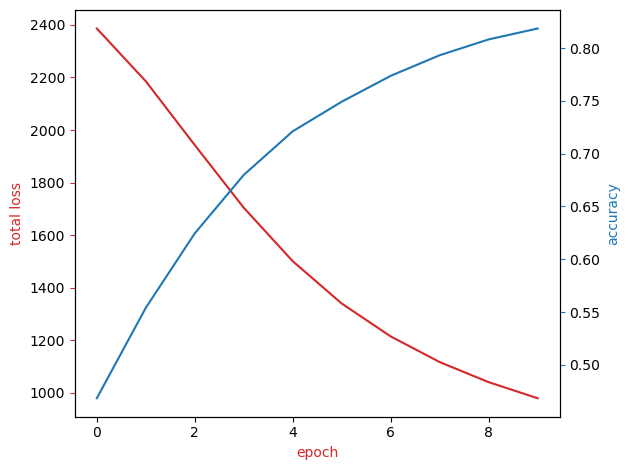

In [19]:
# plot of total loss and acccuracy on validation data over 10 epoches
plot(cum_loss_list, acc_epoch)

In [20]:
# evaluating the trained model on test data
print(f'Preformance of un-trained model:- {evaluate(test_dataloader)} (accuracy)')

Preformance of un-trained model:- 0.8172368421052632 (accuracy)
